In [26]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import scipy
import plotly.express as px
from scipy.stats import mstats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import csv
import fiona
import geopandas
#pd.set_option('display.max_rows', 200)

In [27]:
###Brewster - We are trying to find the Time of Emergence (TOE) of mortality associated with extremes temperatures
###We are finding the TOE by looking at where a particular threshold is crossed, insinuating either increased or decereased mortality over time
###Specifically looking at when (the year) the initial 17th%-tile crosses the 83rd%-tile (or vice versa depending on directionality of the mortality data)
###We will then use the year, extracted from the above calculation, to produce a global map showing every region and what year the TOE is reached

In [28]:
#loading in mortality dataset from hierarchy file (available on Zenodo)
#fn is the full aggregated dataset
fn = "/Users/danielblanco/Documents/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-aggregated.nc4"

#fn1 is the HistClim dataset
fn1 = "/Users/danielblanco/Documents/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim-aggregated.nc4"

In [29]:
#loading in shapefile associated with hierarchy file
shapefile = "/Users/danielblanco/Documents/Mortality_Project/impact-regions-highres-full"

sf = geopandas.read_file(shapefile)
print(sf.head())

    gadmid           hierid  color  ISO  \
0  28115.0       CAN.1.2.28    1.0  CAN   
1  28116.0     CAN.1.17.403    2.0  CAN   
2  28119.0     CAN.2.34.951    3.0  CAN   
3  28120.0  CAN.11.259.4274    4.0  CAN   
4  28124.0  CAN.11.269.4448    5.0  CAN   

                                            geometry  
0  MULTIPOLYGON (((-110.05459 53.30730, -110.0911...  
1  POLYGON ((-111.23055 52.91943, -111.23056 52.9...  
2  POLYGON ((-127.68527 55.29570, -127.68806 55.2...  
3  POLYGON ((-77.73080 55.31879, -77.72983 55.318...  
4  POLYGON ((-66.25940 54.99975, -66.24916 54.999...  


In [30]:
#converting to dataframe
###Brewster-the only way I could easily access the data was by first converting to xr dataset, then to a dataframe (is there a bypass?)
ds = xr.open_dataset(fn)
ds1 = xr.open_dataset(fn1)

df = ds.to_dataframe()
df1 = ds1.to_dataframe()

#isolating individual regions to analyze
DEL = df.loc[df['regions'] =='IND.10.121']    
OSL = df.loc[df['regions'] =='NOR.12']
CHI = df.loc[df['regions'] =='USA.14']        #listed as 'Cook' county
SPB = df.loc[df['regions'] =='BRA']           #double check aggregated version, unaggreagted version not listed as sao paulo
ACC = df.loc[df['regions'] =='GHA.5']
SYD = df.loc[df['regions'] =='AUS.4']         #unaggreageted version split into 
BEI = df.loc[df['regions'] == 'CHN.2']        #double check aggregated version, unaggregated version only has Miyun district

#isolating the regions again for the difference calculation down the road
DEL1 = df1.loc[df['regions'] =='IND.10']
OSL1 = df1.loc[df['regions'] =='NOR.12']
CHI1 = df1.loc[df['regions'] =='USA.14']        
SPB1 = df1.loc[df['regions'] =='BRA']  
ACC1 = df1.loc[df['regions'] =='GHA.5']
SYD1 = df1.loc[df['regions'] =='AUS.4']    
BEI1 = df1.loc[df['regions'] == 'CHN.2']


In [32]:
#Taking rolling 17th, 50th, and 83rd percentiles for all regions
#I have a better method of doing this later in the notebook, this was the first round of analysis
DEL_rolling_17th = DEL['rebased'].rolling(window=30, center = False).quantile(0.17)
DEL_rolling_83rd = DEL['rebased'].rolling(window=30, center = False).quantile(0.83)
DEL_rolling_50th = DEL['rebased'].rolling(window=30, center = False).quantile(0.50)
OSL_rolling_17th = OSL['rebased'].rolling(window=30, center = False).quantile(0.17)
OSL_rolling_83rd = OSL['rebased'].rolling(window=30, center = False).quantile(0.83)
OSL_rolling_50th = OSL['rebased'].rolling(window=30, center = False).quantile(0.50)
CHI_rolling_17th = CHI['rebased'].rolling(window=30, center = False).quantile(0.17)
CHI_rolling_83rd = CHI['rebased'].rolling(window=30, center = False).quantile(0.83)
CHI_rolling_50th = CHI['rebased'].rolling(window=30, center = False).quantile(0.50)
SPB_rolling_17th = SPB['rebased'].rolling(window=30, center = False).quantile(0.17)
SPB_rolling_83rd = SPB['rebased'].rolling(window=30, center = False).quantile(0.83)
SPB_rolling_50th = SPB['rebased'].rolling(window=30, center = False).quantile(0.50)
ACC_rolling_17th = ACC['rebased'].rolling(window=30, center = False).quantile(0.17)
ACC_rolling_83rd = ACC['rebased'].rolling(window=30, center = False).quantile(0.83)
ACC_rolling_50th = ACC['rebased'].rolling(window=30, center = False).quantile(0.50)
SYD_rolling_17th = SYD['rebased'].rolling(window=30, center = False).quantile(0.17)
SYD_rolling_83rd = SYD['rebased'].rolling(window=30, center = False).quantile(0.83)
SYD_rolling_50th = SYD['rebased'].rolling(window=30, center = False).quantile(0.50)
BEI_rolling_17th = BEI['rebased'].rolling(window=30, center = False).quantile(0.17)
BEI_rolling_83rd = BEI['rebased'].rolling(window=30, center = False).quantile(0.83)
BEI_rolling_50th = BEI['rebased'].rolling(window=30, center = False).quantile(0.50)


In [36]:
#Simple difference between full income-full adaptation and Histclim
DELdiff = DEL['rebased']- DEL1['rebased']
OSLdiff = OSL['rebased'] - OSL1['rebased']
CHIdiff = CHI['rebased'] - CHI1['rebased']
SPBdiff = SPB['rebased'] - SPB1['rebased']
ACCdiff = ACC['rebased'] - ACC1['rebased']
SYDdiff = SYD['rebased'] - SYD1['rebased']
BEIdiff = BEI['rebased'] - BEI1['rebased']

#Taking rolling 17th, 50th, and 83rd percentiles for all differences
DEL_diffrolling_17th = DELdiff.rolling(window=30, center = False).quantile(0.17)
DEL_diffrolling_83rd = DELdiff.rolling(window=30, center = False).quantile(0.83)
DEL_diffrolling_50th = DELdiff.rolling(window=30, center = False).quantile(0.50)
OSL_diffrolling_17th = OSLdiff.rolling(window=30, center = False).quantile(0.17)
OSL_diffrolling_83rd = OSLdiff.rolling(window=30, center = False).quantile(0.83)
OSL_diffrolling_50th = OSLdiff.rolling(window=30, center = False).quantile(0.50)
CHI_diffrolling_17th = CHIdiff.rolling(window=30, center = False).quantile(0.17)
CHI_diffrolling_83rd = CHIdiff.rolling(window=30, center = False).quantile(0.83)
CHI_diffrolling_50th = CHIdiff.rolling(window=30, center = False).quantile(0.50)
SPB_diffrolling_17th = SPBdiff.rolling(window=30, center = False).quantile(0.17)
SPB_diffrolling_83rd = SPBdiff.rolling(window=30, center = False).quantile(0.83)
SPB_diffrolling_50th = SPBdiff.rolling(window=30, center = False).quantile(0.50)
ACC_diffrolling_17th = ACCdiff.rolling(window=30, center = False).quantile(0.17)
ACC_diffrolling_83rd = ACCdiff.rolling(window=30, center = False).quantile(0.83)
ACC_diffrolling_50th = ACCdiff.rolling(window=30, center = False).quantile(0.50)
SYD_diffrolling_17th = SYDdiff.rolling(window=30, center = False).quantile(0.17)
SYD_diffrolling_83rd = SYDdiff.rolling(window=30, center = False).quantile(0.83)
SYD_diffrolling_50th = SYDdiff.rolling(window=30, center = False).quantile(0.50)
BEI_diffrolling_17th = BEIdiff.rolling(window=30, center = False).quantile(0.17)
BEI_diffrolling_83rd = BEIdiff.rolling(window=30, center = False).quantile(0.83)
BEI_diffrolling_50th = BEIdiff.rolling(window=30, center = False).quantile(0.50)





In [37]:
#calculating where 83rd or 17th%-tile crosses x-axis
minimum_value_year = np.absolute(SYD_rolling_17th)
intercept = minimum_value_year.argmin()
#TOE_label = 1981 + intercept
intercept

###Brewster - is there another way to write this? Such as a for loop to enumerate?

52

In [38]:
#using this cell to find all the years the initial 17th%-tile is greater than the any o the 83rd%-tile (or vice versa) 
a = np.where(BEI_rolling_17th.iloc[29] >=BEI_rolling_83rd)
a = np.asarray(a)
amin = a[0].min()
TOE_labela = 1981 + amin
a

array([[ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119]])

([<matplotlib.axis.XTick at 0x284c00820>,
 [Text(19, 0, '2000'),
  Text(39, 0, '2020'),
  Text(59, 0, '2040'),
  Text(79, 0, '2060'),
  Text(99, 0, '2080'),
  Text(119, 0, '2100')])

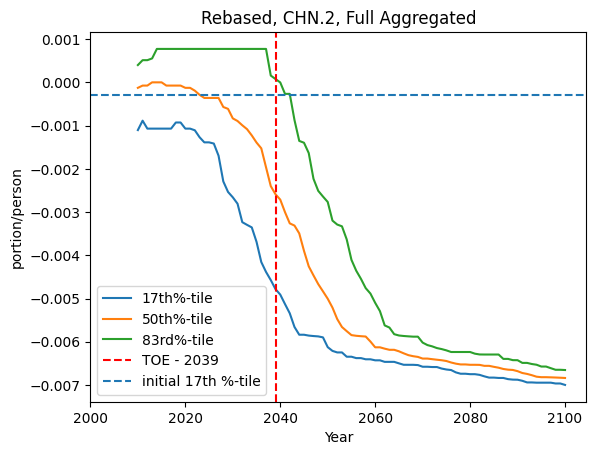

In [39]:
#rolling percentiles plot, NEED TO FIX X-AXIS
a = [19,39,59,79,99,119]
DEL_rolling_17th.plot(label="17th%-tile")
DEL_rolling_50th.plot(label="50th%-tile")
DEL_rolling_83rd.plot(label="83rd%-tile")
plt.title("Rebased, CHN.2, Full Aggregated")
plt.ylabel("portion/person")
plt.xlabel("Year")
plt.axvline(x = amin, linestyle='--',c='r' ,label = "TOE - " + str(TOE_labela) )
plt.axhline(y=BEI_rolling_17th.iloc[29], linestyle='--', label = "initial 17th %-tile")
plt.legend()
plt.xticks(a , ['2000','2020','2040','2060','2080','2100'])

In [35]:
#loading region ID's to be fed into for loop - this is the same as the hierid
regionID = pd.read_csv("/Users/danielblanco/Documents/Mortality_Project/RegionID.csv").drop_duplicates().reset_index()
REGIONS = regionID['region']


In [36]:
#Defining function to take quantiles across regions
#REGIONS =['USA.14','IND.10.121','NOR.12','BRA']
quants = [0.17,0.50,0.83]
def Quantiles(region, quant):
    RegionCode = df.loc[df['regions'] ==f"{region}"]
    Rolling = (RegionCode['rebased']).rolling(window=30, center = False).quantile(quant)
    return Rolling
    


In [37]:
#appending quantiles to new array
result_list = []
for i in range(len(REGIONS)):
    region_results = []
    for j in range(len(quants)):
        quantile_result = Quantiles(REGIONS[i], quants[j])
        region_results.append(quantile_result)
        result_list.append(region_results)

In [38]:
###Brewster - this is mainly where I need help. It won't let me conver to xarray, and I need the data formatted 
###Ideally, I need the format to go: year, region, hierid, 17th%-tile, 50th%-tile, and 83rd%-tile.
###Have thusfar been unable to add the hierid data to correctly match the associated region
###The percentiles are stacked horizontally rather than in vertical columns

#converting array to xarray (unable)
#result_list = xr.DataArray(result_list)
result_list

[[Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64)],
 [Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64)],
 [Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64),
  Series([], Name: rebased, dtype: float64)],
 [year  region
  1981  2196           NaN
  1982  2196           NaN
  1983  2196           NaN
  1984  2196           NaN
  1985  2196           NaN
                    ...   
  2096  2196     -0.008524
  2097  2196     -0.008639
  2098  2196     -0.008837
  2099  2196     -0.008969
  2100  2196     -0.008969
  Name: rebased, Length: 120, dtype: float64,
  year  region
  1981  2196           NaN
  1982  2196           NaN
  1983  2196           NaN
  1984  2196           NaN
  1985  2196           NaN
                    ...   
  2096  2196     -0.008050
  2097  2196     -0.008085
  2

In [40]:
# Function to calculate meshgrid diff between full aggregated data and HistClim

def fn_diff(Xvar,Yvar,step,quantile):
    tot_len=len(Xvar[0])
    diff=[]
    for ii in range(tot_len-step):
        if ii == (tot_len):
            break #break loop if it exceeds window.
        else:
            diff_var=Xvar[0+ii:ii+step,0+ii:ii+step] - Yvar[0+ii:ii+step,0+ii:ii+step]
            quant_diff = np.quantile(diff_var, quantile)
            diff.append(quant_diff)
    return diff



In [41]:
#creating np.meshgrid dataframe between full income/full adapt. and Histclim
xx,yy = np.meshgrid(CKT['rebased'],CKT1['rebased'])
step=30

diff17 = fn_diff(xx,yy,30,.17)
diff50 = fn_diff(xx,yy,30,.50)
diff83 = fn_diff(xx,yy,30,.83)


#stack results all at once
Diff17 = np.vstack(diff17)
Diff50 = np.vstack(diff50)
Diff83 = np.vstack(diff83)

#creating dataframe to store stacked results
data = pd.DataFrame()


data['17th_percentile'] = Diff17.flatten()
data['50th_percentile'] = Diff50.flatten()
data['83rd_percentile'] = Diff83.flatten()


data = data.reindex(data.index.tolist() + list(range(30))).shift(30)
data = data.reset_index()
data = data.iloc[:120]




In [43]:
###Brewster - is there another way to do this that doesn't involve hard coding?
###Also, is there a way to do this across all regions using the data from 'result_list'?

#calculating where 83rd or 17th%-tile crosses x-axis
minimum_value = np.absolute(data['17th_percentile'])
intercept = minimum_value.argmin()
TOE_label = 1981 + intercept
intercept



106

In [44]:
a = df.reset_index()
b = a['year']
b

0         1981
1         1981
2         1981
3         1981
4         1981
          ... 
681355    2100
681356    2100
681357    2100
681358    2100
681359    2100
Name: year, Length: 681360, dtype: int64

In [ ]:
#quantiles plots using simple substraction and meshgrid methodology
data['17th_percentile'].plot(label = "17th%-tile MG", linestyle = 'dashed')
data['50th_percentile'].plot(label = "50th%-tile MG",linestyle = 'dashed')
data['83rd_percentile'].plot(label = "83rd%-tile MG",linestyle = 'dashed')
CKT_diffrolling_17th.plot(label="17th%-tile SS")
CKT_diffrolling_50th.plot(label="50th%-tile SS")
CKT_diffrolling_83rd.plot(label="83rd%-tile SS")
plt.title("Rebased, AUS.4, Full Aggregated minus Histclim")
plt.ylabel("portion/person")
plt.xlabel("Year")
plt.axvline(x = intercept, linestyle='--',c='r' ,label = "TOE - " + str(TOE_label) )
#plt.axhline(y=0.000186, linestyle='--',c='g', label = "initial 83rd %-tile")
plt.legend()
plt.xticks(b)

([<matplotlib.axis.XTick at 0x294cf25e0>,
  ...],
 [Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Text(1981, 0, ''),
  Tex

In [165]:
###Brewster - ideally we want to add the TOE year as a column within this shapefile dataset
###The final product with be a color coded map showing the TOE for each region
###Once we have the data above correctly formatted this should be easy enough
shapefile = "/Users/danielblanco/Documents/Mortality_Project/impact-regions-highres-full"
#shapefile="agglomerated-world-new.shp"
sf = geopandas.read_file(shapefile)
print(sf.head())

    gadmid           hierid  color  ISO  \
0  28115.0       CAN.1.2.28    1.0  CAN   
1  28116.0     CAN.1.17.403    2.0  CAN   
2  28119.0     CAN.2.34.951    3.0  CAN   
3  28120.0  CAN.11.259.4274    4.0  CAN   
4  28124.0  CAN.11.269.4448    5.0  CAN   

                                            geometry  
0  MULTIPOLYGON (((-110.05459 53.30730, -110.0911...  
1  POLYGON ((-111.23055 52.91943, -111.23056 52.9...  
2  POLYGON ((-127.68527 55.29570, -127.68806 55.2...  
3  POLYGON ((-77.73080 55.31879, -77.72983 55.318...  
4  POLYGON ((-66.25940 54.99975, -66.24916 54.999...  


In [188]:
sf['17th%-tile'] = data['17th_percentile']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
115   -0.000930
116   -0.000970
117   -0.001024
118   -0.001035
119   -0.001060
Name: 17th_percentile, Length: 120, dtype: float64